## Web Project

In [100]:
from dotenv import load_dotenv
import os
import json
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## API

In [101]:
#Primera prueba API (allPrices)
source = "https://www.bitstamp.net/api/v2/transactions/btceur/?time=day"
exchangeInfo = requests.get(source)
json_exchangeInfo = exchangeInfo.json()

In [102]:
#sym = list(map(lambda x: {"symbol":x["symbol"],"price":x["price"]}, json_exchangeInfo))
#crypto = list({v["symbol"]:v for v in sym}.values())
#print(sym)
col_clean = ['amount','tid','type']
crypto_all = pd.DataFrame(json_exchangeInfo).drop(col_clean, axis=1).rename(index=int, columns={"date":"UnixTime",
                                                                                               "price":"Exchange"})

col_type = ['UnixTime','Exchange']
crypto_all[col_type] = crypto_all[col_type].apply(pd.to_numeric, errors='coerce')
#crypto_all.to_csv('./output/crypto_all.csv', index=False, encoding = 'utf-8')
crypto_all_r = crypto_all.reindex(index=crypto_all.index[::-1])
crypto_all_r.to_csv('./output/crypto_all_r.csv', index=False, encoding = 'utf-8')
crypto_ex1 = crypto_all_r.drop_duplicates(subset='Exchange', keep="last").sort_index()
crypto_ex2 = crypto_ex1.drop_duplicates(subset='UnixTime', keep="last").sort_index().reset_index().drop(['index','UnixTime'],axis=1)
#display(crypto_all.dtypes.eq(object))
#crypto_all = crypto_all.apply(crypto_all.to_numeric, errors='coerce')
#print(crypto_all)

display(crypto_ex2)

,Exchange
0,3197.20
1,3192.45
2,3197.16
3,3197.04
4,3198.97
5,3199.48
6,3197.23
7,3190.17
8,3197.45
9,3197.50


In [103]:
crypto_all.to_csv('./output/crypto_all_reindex.csv', index=False, encoding = 'utf-8')

In [105]:
stats_ex = crypto_ex2.describe().transpose()
stats_ex['IQR'] = stats_ex['75%'] - stats_ex['25%']
display(stats_ex)
out_ex = pd.DataFrame(columns=crypto_ex2.columns)
for col in stats_ex.index:
    iqr = stats_ex.at[col,'IQR']
    cutoff = iqr * 1.5
    lower = stats_ex.at[col,'25%'] - cutoff
    upper = stats_ex.at[col,'75%'] + cutoff
    results = crypto_ex2[(crypto_ex2[col] < lower) | 
                   (crypto_ex2[col] > upper)].copy()
    out_ex = out_ex.append(results)
display(out_ex)


,count,mean,std,min,25%,50%,75%,max,IQR
Exchange,1601.0,3190.593585,11.470252,3168.58,3181.1,3190.95,3197.68,3230.96,16.58


,Exchange
1456,3224.66
1457,3224.64
1459,3224.35
1460,3228.12
1461,3224.50
1462,3223.65
1464,3223.24
1466,3226.68
1467,3225.31
1468,3224.85


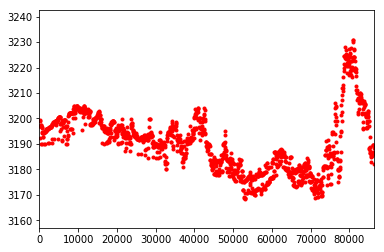

y=-0.000113x+(3195.454904)


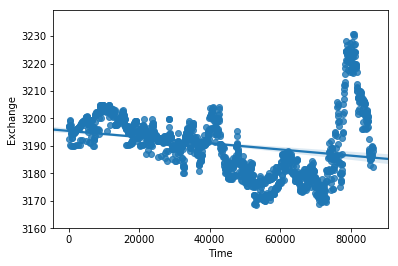

In [116]:
time_exchange = np.arange(0,86400,(86400/len(crypto_ex2)))
time_ex_pandas = pd.DataFrame(time_exchange)
#display(time_ex_pandas)
#display(crypto_ex2)
plt.plot(time_exchange, crypto_ex2['Exchange'], 'r.')
plt.axis([0, 86400, stats_ex.iloc[0]['min']-stats_ex.iloc[0]['std'], stats_ex.iloc[0]['max']+stats_ex.iloc[0]['std']])
plt.show()

# calc the trendline
z = np.polyfit(time_exchange, crypto_ex2['Exchange'], 1)
p = np.poly1d(z)
#plt.plot(time_exchange,p(time_exchange),"g--")
# the line equation:
print("y=%.6fx+(%.6f)"%(z[0],z[1]))

crypto_reg_ex = time_ex_pandas.join(crypto_ex2).rename(index=int, columns={0:"Time"})
#display(crypto_reg)
sns.regplot(x="Time", y="Exchange", data=crypto_reg_ex)

## Web Scraping

In [127]:
url_pattern = 'https://localbitcoins.com/es/buy-bitcoins-online/eur/?page=%s' #luego será URL PATTERN
n = 10
scrap = []
for p in range(1,n+1):
    scrap_localInfo = []
    localInfo = requests.get(url_pattern%p)
    soup = BeautifulSoup(localInfo.text, 'html.parser') #no se cual es la diferencia entre 'lxml' y lo que puso Alberto
    for a in soup.find_all('td', class_="column-price"):
        scrap_localInfo.append(a.get_text('column-price'))
    for i in range(len(scrap_localInfo)):
        scrap_localInfo[i] = re.sub('\s','',scrap_localInfo[i]).replace('EUR', '').replace(',','')
    for e in range(len(scrap_localInfo)):
        scrap_localInfo[e] = float(scrap_localInfo[e])
    scrap.append(scrap_localInfo)
local = [e for x in scrap for e in x]
crypto_local = pd.DataFrame(local).rename(index=int, columns={0:"Permutas"})

display(crypto_local)



,Permutas
0,3223.88
1,3230.89
2,3236.54
3,3248.68
4,3248.68
5,3250.00
6,3250.00
7,3261.91
8,3262.23
9,3264.22


In [128]:
display(crypto_local.dtypes)
display(len(crypto_local))

Permutas    float64
dtype: object

472

In [129]:
stats_loc = crypto_local.describe().transpose()
stats_loc['IQR'] = stats_loc['75%'] - stats_loc['25%']
display(stats_loc)
out_loc = pd.DataFrame(columns=crypto_local.columns)
for col in stats_loc.index:
    iqr = stats_loc.at[col,'IQR']
    cutoff = iqr * 1.5
    lower = stats_loc.at[col,'25%'] - cutoff
    upper = stats_loc.at[col,'75%'] + cutoff
    results = crypto_local[(crypto_local[col] < lower) | 
                   (crypto_local[col] > upper)].copy()
    out_loc = out_loc.append(results)
display(out_loc,out_loc.count())

,count,mean,std,min,25%,50%,75%,max,IQR
Permutas,472.0,4452.585339,3878.224936,3173.59,3472.97,3792.165,4458.09,66845.95,985.12


,Permutas
433,5971.44
434,6058.55
435,6058.68
436,6100.00
437,6100.00
438,6100.00
439,6249.87
440,6327.82
441,6327.82
442,6327.82


Permutas    32
dtype: int64

472


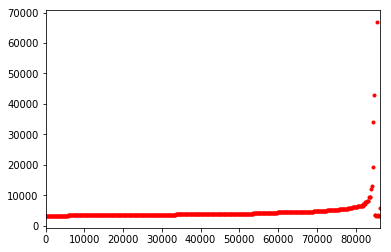

y=0.052890x+(2172.590787)


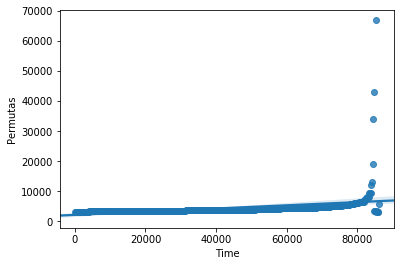

In [130]:
time_local = np.arange(0,86400,(86400/len(crypto_local)))
time_loc_pandas = pd.DataFrame(time_local)
print(len(time_local))
plt.plot(time_local, crypto_local['Permutas'], 'r.')
plt.axis([0, 86400, stats_loc.iloc[0]['min']-stats_loc.iloc[0]['std'], stats_loc.iloc[0]['max']+stats_loc.iloc[0]['std']])
plt.show()
# calc the trendline
z = np.polyfit(time_local, crypto_local['Permutas'], 1)
p = np.poly1d(z)
#plt.plot(time_local,p(time_local),"g--")
# the line equation:
print("y=%.6fx+(%.6f)"%(z[0],z[1]))

crypto_reg_loc = time_loc_pandas.join(crypto_local).rename(index=int, columns={0:"Time"})
#display(crypto_reg)
sns.regplot(x="Time", y="Permutas", data=crypto_reg_loc)